In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf
from scipy import signal


In [171]:
# Шаг 1. Загрузка данных и предобработка
# file_path = '/Users/danilalipatov/Downloads/resemple_data_cat-last.xlsx'
file_path = '/Users/danilalipatov/PycharmProjects/diploma/resemple_data_cat_level.xlsx'
df = pd.read_excel(file_path)
df["identifier"] = df["identifier"].astype(str)
df.columns

Index(['Unnamed: 0', 'identifier', 'agency', '_ro_type', 'resampled_dates',
       'resampled_values', 'rating_category'],
      dtype='object')

In [840]:
df["resampled_dates"] = pd.to_datetime(df["resampled_dates"])
df_result = df.dropna(subset=["identifier", "resampled_values", "resampled_dates", "agency", "_ro_type"])
# df_result = df_result[(df_result["agency"] == "Expert RA") & (df_result["_ro_type"] == "CBNK - кредитная организация")]
df_result = df_result[(df_result["agency"] == "Expert RA")]
df_result = df_result[df_result["resampled_dates"].dt.year >= 2016]
df_result["resampled_values"] = df_result["resampled_values"].astype(int)
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].dropna().nunique() > 2)

# Убираем компании, у которых непустых значений меньше порога
threshold = 1  # Например, минимум 10 непустых наблюдений
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].count() >= threshold)


In [842]:
df_result["identifier"].unique()

array(['5200000046', '7713011336', '7727051787', '1435133520',
       '6623029538', '5244009279', '7706662633', '4401116480',
       '7707050464', '7701045732', '7835905108', '5260059340',
       '7719780320', '7750056688', '6027006032', '1326024785',
       '7729003482', '7710045520', '5407197984', '7725520440',
       '7709129705', '3906098008', '2309029802', '1653011835',
       '5200000222', '7701041336', '7831000027', '7825508140',
       '7705041231', '7705619586', '5321059541', '7727499177',
       '2702030634', '7706548313', '7719668640', '7713001271',
       '1102011300', '7705717209', '7729399756', '7804493447',
       '7744000990', '7705522866', '7414006722', '7750004009',
       '2801023444', '2465029704', '8904002359', '7707492166',
       '6312013969', '7727065444', '7730059592', '1653003834',
       '5617000264', '7421000200', '6164077483', '6829000028',
       '7838408320', '4214005204', '1700000350', '1650014919',
       '7831000080', '7704300652', '2225019491', '77181

In [844]:
len(df_result["identifier"].unique())

257

In [846]:
# === Шаг 1. Подготовка данных ===
df_agg = df_result  # Данные уже агрегированы по месяцам

# === Шаг 2. Формирование сводной таблицы (pivot) ===
pivot_df = df_agg.pivot(index="resampled_dates", columns="identifier", values="resampled_values")
# pivot_df = pivot_df.loc[:, pivot_df.count() > 5] 

In [849]:
print(pivot_df)

identifier       106000547  1102011300  1326021671  1326024785  1435126628  \
resampled_dates                                                              
2016-01-31             NaN         NaN         NaN         NaN         NaN   
2016-02-29             NaN         NaN         NaN         NaN         NaN   
2016-03-31             NaN         NaN         NaN         NaN         NaN   
2016-04-30             NaN         NaN         NaN         NaN         NaN   
2016-05-31             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2024-07-31            12.0        20.0        20.0        15.0        20.0   
2024-08-31            12.0        20.0        20.0        15.0        20.0   
2024-09-30            12.0        20.0        20.0        15.0        20.0   
2024-10-31            12.0        20.0        20.0        15.0        20.0   
2024-11-30            12.0        20.0        20.0        15.0  

In [851]:
total_nan = pivot_df.isna().sum().sum()
print(f"Общее количество NaN: {total_nan}")
# pivot_df = pivot_df.loc[:, pivot_df.nunique(dropna=True) > 1]

Общее количество NaN: 5547


In [853]:
correlation = pivot_df["106000547"].corr(pivot_df["1101300820"])
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].unique(), pivot_df["1101300820"].unique())

KeyError: '1101300820'

In [855]:
# Проверяем количество ненулевых значений
print(pivot_df[["106000547", "1101300820"]].count())

# Проверяем дисперсию
print(pivot_df[["106000547", "1101300820"]].var())
df_corr = pivot_df[["106000547", "1101300820"]].dropna(how="any")
correlation = df_corr["106000547"].corr(df_corr["1101300820"], method="spearman")
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].dropna().unique(), pivot_df["1101300820"].dropna().unique())

KeyError: "['1101300820'] not in index"

In [857]:
len(pivot_df.columns) * len(pivot_df)

27499

In [859]:
pivot_df.dtypes
print(pivot_df.notna().sum())
print(pivot_df.var())
print(pivot_df.nunique())

identifier
106000547     94
1102011300    96
1326021671    94
1326024785    96
1435126628    94
              ..
8602103061    92
8904002359    96
9703024202    62
9718077239    36
9725000621    87
Length: 257, dtype: int64
identifier
106000547     0.500572
1102011300    0.518311
1326021671    6.902425
1326024785    3.504825
1435126628    9.746625
                ...   
8602103061    0.312828
8904002359    0.494298
9703024202    2.078265
9718077239    2.600000
9725000621    1.051323
Length: 257, dtype: float64
identifier
106000547     4
1102011300    3
1326021671    4
1326024785    5
1435126628    5
             ..
8602103061    3
8904002359    3
9703024202    3
9718077239    3
9725000621    3
Length: 257, dtype: int64


Cross-Correlation Matrix (Pearson) between Companies (INN):
identifier  106000547  1102011300  1326021671  1326024785  1435126628  \
identifier                                                              
1435133520  -0.678708   -0.409708   -0.781500   -0.764165   -0.702823   
1435138944  -0.369129    0.406179   -0.476814   -0.409910    0.053749   
1835047032  -0.132168    0.508511   -0.402499   -0.247507   -0.131619   
2801023444  -0.687305    0.088454   -0.570561   -0.417340   -0.181131   
3327100351  -0.220418    0.393355   -0.352568   -0.212646    0.139409   
3666068423  -0.591330    0.021809   -0.710515   -0.676268   -0.375574   
4101020152   0.726009    0.245072    0.860051    0.890132    0.445400   
4214005204  -0.784861   -0.405606   -0.616752   -0.600366   -0.376621   
5244009279  -0.808771   -0.271190   -0.878223   -0.878997   -0.459835   
5407197984  -0.418800    0.417837   -0.574621   -0.463768   -0.176319   
5617000264   0.863425    0.523669    0.696448    0.708057    0.5

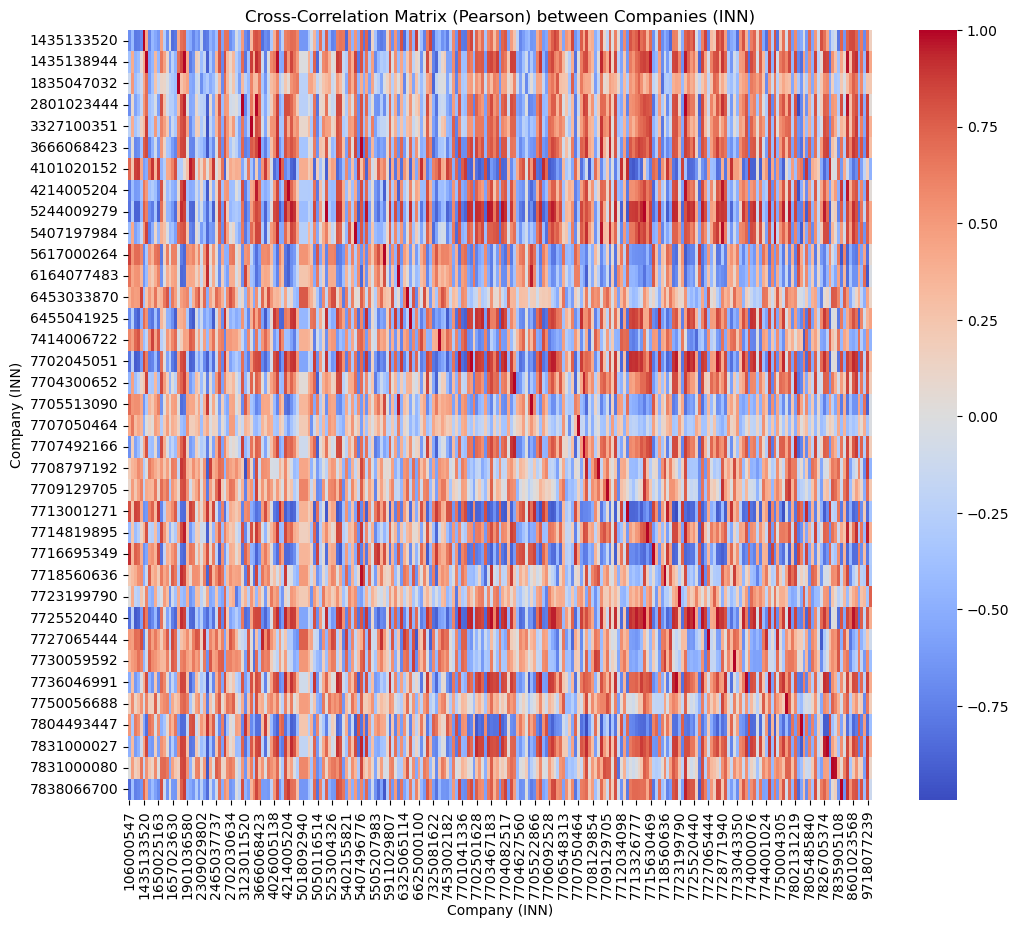

36 257


In [861]:
# === Шаг 3. Вычисление кросс-корреляционной матрицы ===
cross_corr_matrix = pivot_df.corr(method="spearman")  # Можно заменить на 'spearman' или 'kendall', 'pearson'
cross_corr_matrix = cross_corr_matrix.dropna(axis=0)  # Удалить строки, где все значения NaN
cross_corr_matrix = cross_corr_matrix.dropna(axis=1)  # Удалить столбцы, где все значения NaN
# === Шаг 4. Вывод результатов ===
print("Cross-Correlation Matrix (Pearson) between Companies (INN):")
print(cross_corr_matrix)

# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()
print(len(cross_corr_matrix.index), len(cross_corr_matrix.columns))

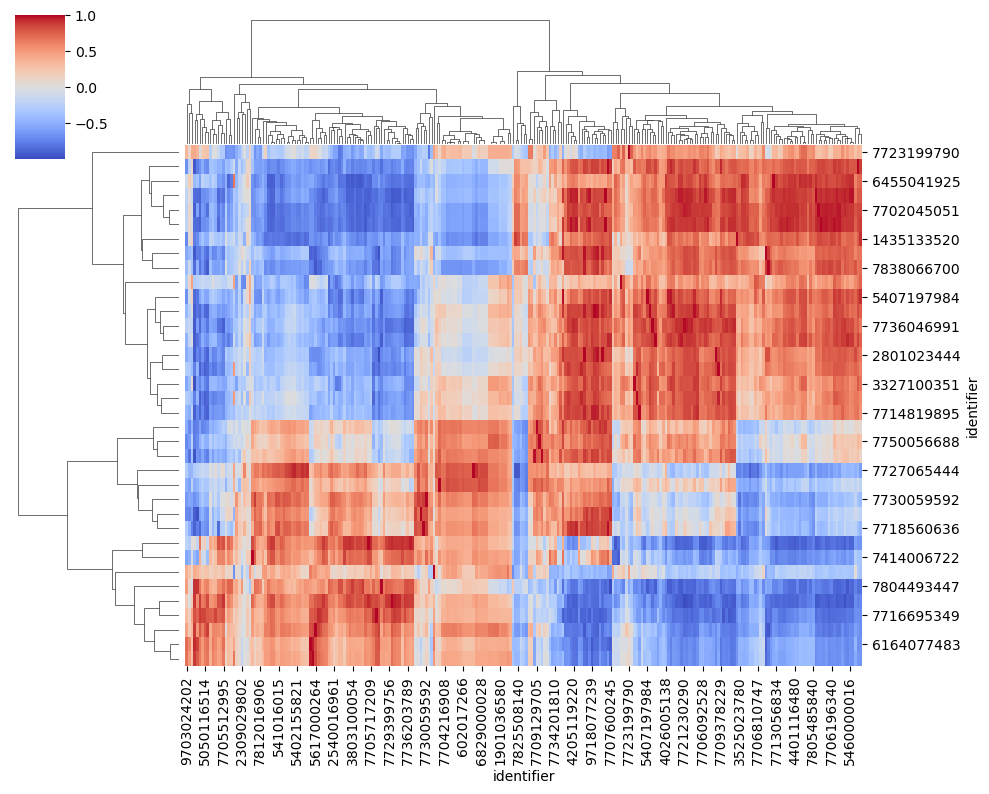

In [862]:
sns.clustermap(cross_corr_matrix.fillna(0), cmap='coolwarm', figsize=(10, 8))
plt.show()

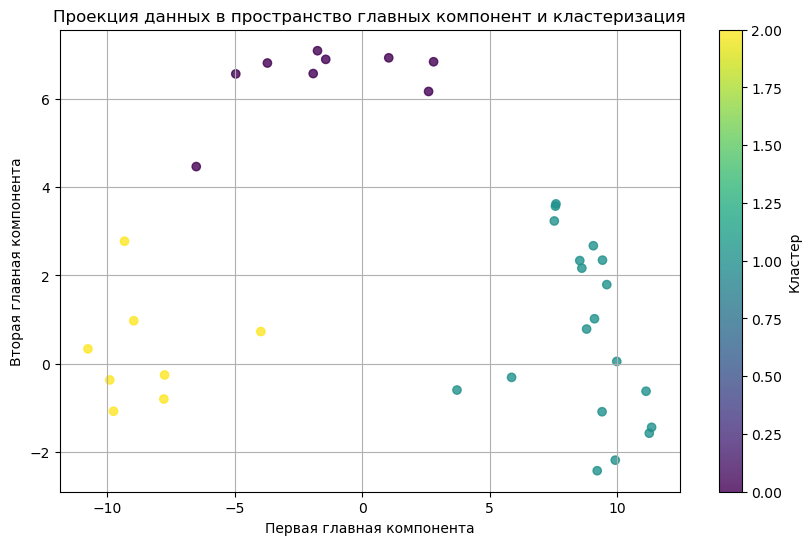

Топ-5 компаний по вкладу в главные компоненты: ['5407496776', '7842393933', '3620013012', '1841070689', '2462067684']
Топ-5 плохих компаний по вкладу в главные компоненты: ['5835115642', '7710045520', '5042015329', '2309029802', '7816430057']


In [864]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix.fillna(0))

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу
bad_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 bad компнаний по вкладу
# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))
print("Топ-5 плохих компаний по вкладу в главные компоненты:", list(bad_companies))

In [867]:
# Оцениваем вклад компаний в главные компоненты (по абсолютному значению)
importance = np.abs(pca.components_[0])  # Берём 1-ю главную компоненту
bottom_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 с наименьшим вкладом

# Дополнительно проверим дисперсию рейтинга
rating_variance = pivot_df.var()
low_variance_companies = rating_variance.nsmallest(5).index  # Компании с минимальной дисперсией

# Выведем результат
print("Топ-5 компаний с наименьшим вкладом в главные компоненты:", list(bottom_companies))
print("Топ-5 компаний с минимальной дисперсией рейтинга:", list(low_variance_companies))

NameError: name 'pca' is not defined

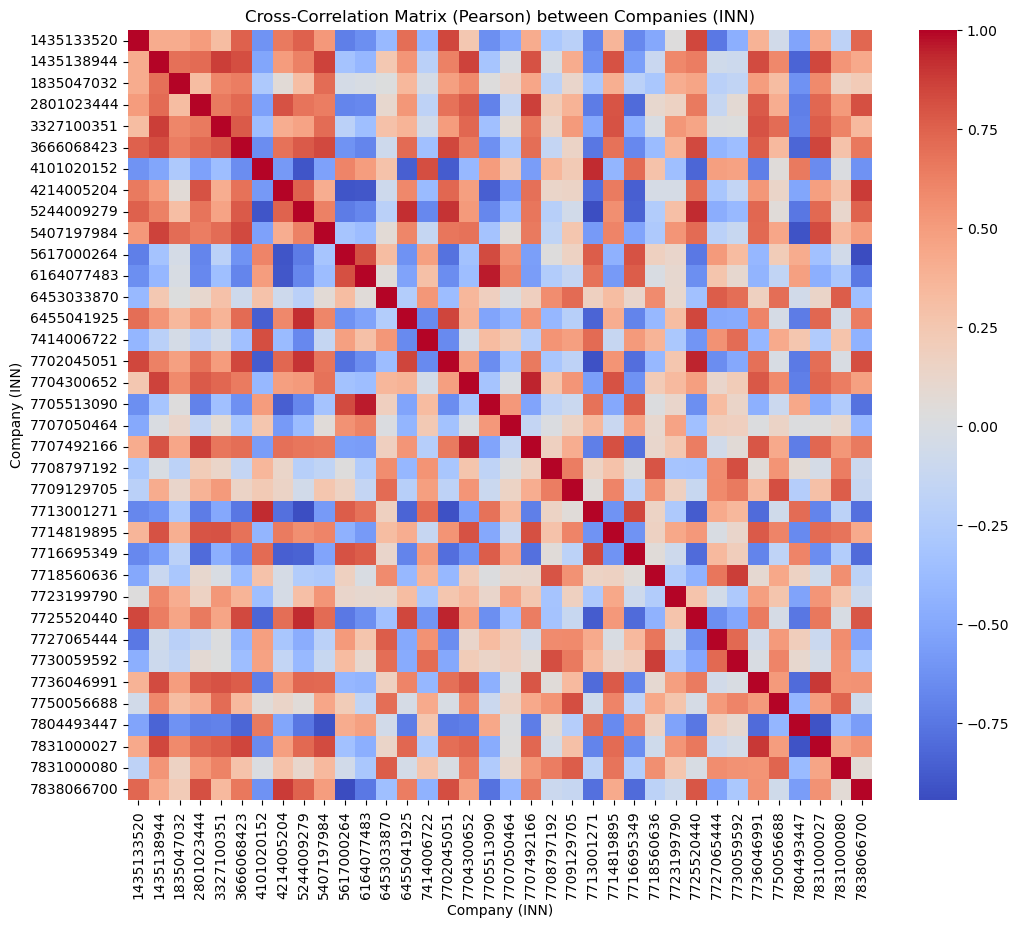

In [869]:
nan_indices = cross_corr_matrix.isna().any(axis=1)  # Идентификаторы с NaN
valid_indices = cross_corr_matrix.index[~nan_indices]  # Только корректные идентификаторы

# Формируем симметричную матрицу
cross_corr_matrix = cross_corr_matrix.loc[valid_indices, valid_indices]


# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()

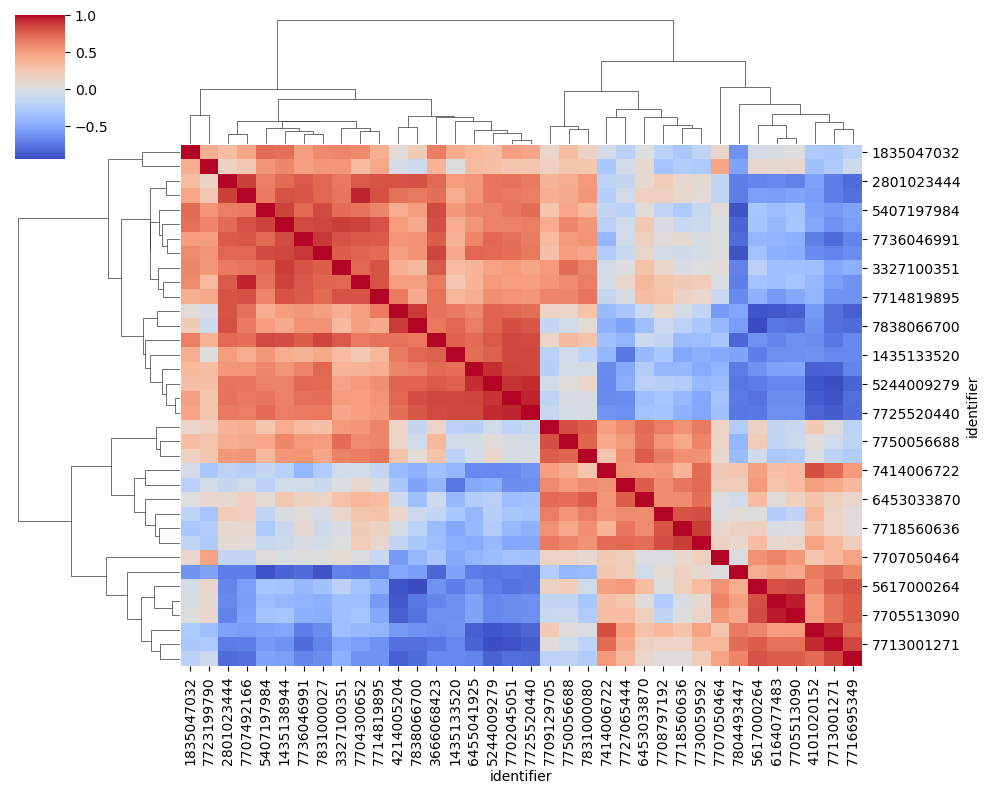

In [871]:
sns.clustermap(cross_corr_matrix, cmap='coolwarm', figsize=(10, 8))
plt.show()

In [873]:
len(cross_corr_matrix.columns), len(cross_corr_matrix.index)

(36, 36)

In [875]:
U, S, Vt = np.linalg.svd(cross_corr_matrix)

In [877]:
U, S, Vt

(array([[-0.17883309,  0.14654632, -0.04590042, ..., -0.20467555,
         -0.28450469,  0.12940002],
        [-0.19355081, -0.13689522,  0.17589135, ..., -0.15189835,
          0.07508891,  0.38151345],
        [-0.11789   , -0.05664764,  0.29567239, ...,  0.11509251,
          0.04057968, -0.03815794],
        ...,
        [-0.20163263, -0.10227443,  0.1419808 , ..., -0.13032533,
         -0.09862454, -0.00321604],
        [-0.07392116, -0.30253606, -0.05802304, ..., -0.04751134,
         -0.10234208,  0.15259239],
        [-0.1956632 ,  0.08723603, -0.17324146, ...,  0.29490707,
         -0.25480908, -0.06156353]]),
 array([1.73719171e+01, 7.93476849e+00, 3.95514846e+00, 1.50941913e+00,
        1.00340125e+00, 8.40580857e-01, 6.70638803e-01, 5.13349584e-01,
        4.23015297e-01, 3.65647838e-01, 2.60718461e-01, 2.09586758e-01,
        1.93104174e-01, 1.57729358e-01, 1.38591430e-01, 1.25570827e-01,
        1.14775030e-01, 1.04758118e-01, 7.70477920e-02, 6.50891302e-02,
        6.193

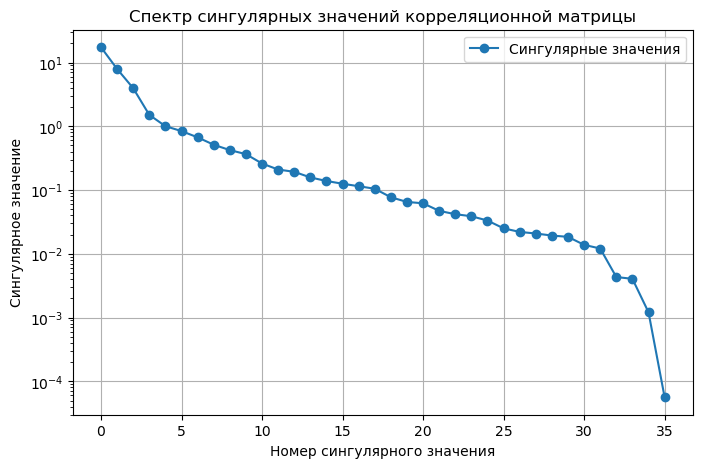

[0.47726347 0.69525755 0.80391843 0.84538712 0.87295384]


In [879]:
# Строим спектр сингулярных значений
plt.figure(figsize=(8, 5))
plt.plot(S, marker="o", linestyle="-", label="Сингулярные значения")
plt.yscale("log")
plt.xlabel("Номер сингулярного значения")
plt.ylabel("Сингулярное значение")
plt.title("Спектр сингулярных значений корреляционной матрицы")
plt.legend()
plt.grid()
plt.show()

# Доля информации, объясняемая первыми 5 сингулярными значениями
explained_variance = np.cumsum(S) / np.sum(S)
print(explained_variance[:5])


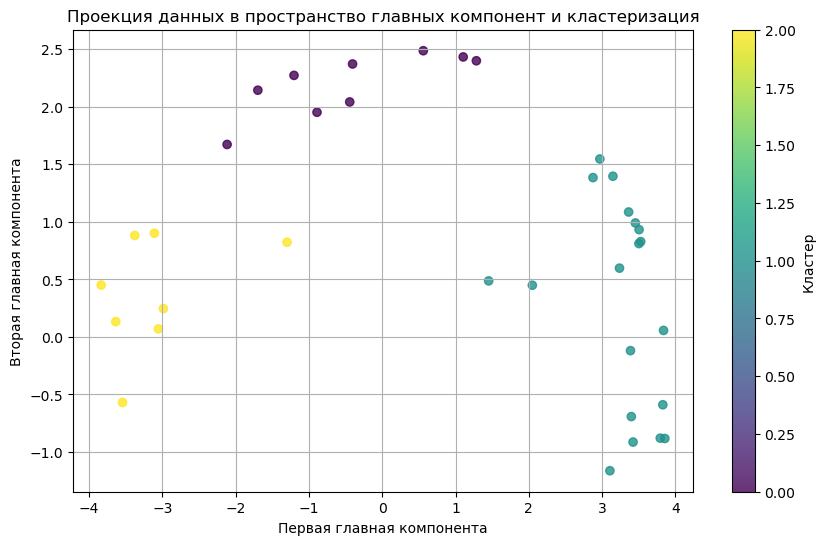

Топ-5 компаний по вкладу в главные компоненты: ['7714819895', '7704300652', '7727065444', '7750056688', '7831000080']
Топ-5 компаний по вкладу в главные компоненты: ['7723199790', '1835047032', '7707050464', '6164077483', '7705513090']


In [880]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix)

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу

# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))
bad_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 bad компнаний по вкладу
# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(bad_companies))

In [883]:
relevant_companies = list(cross_corr_matrix.index.intersection(pivot_df.columns))
# relevant_companies = list(map(int, cross_corr_matrix.index.intersection(pivot_df.columns)))
len(relevant_companies)

36

In [885]:
relevant_companies

['1435133520',
 '1435138944',
 '1835047032',
 '2801023444',
 '3327100351',
 '3666068423',
 '4101020152',
 '4214005204',
 '5244009279',
 '5407197984',
 '5617000264',
 '6164077483',
 '6453033870',
 '6455041925',
 '7414006722',
 '7702045051',
 '7704300652',
 '7705513090',
 '7707050464',
 '7707492166',
 '7708797192',
 '7709129705',
 '7713001271',
 '7714819895',
 '7716695349',
 '7718560636',
 '7723199790',
 '7725520440',
 '7727065444',
 '7730059592',
 '7736046991',
 '7750056688',
 '7804493447',
 '7831000027',
 '7831000080',
 '7838066700']

In [887]:
pivot_df_hurst = pivot_df.loc[:, pivot_df.columns.intersection(relevant_companies)]
pivot_df_hurst

identifier,1435133520,1435138944,1835047032,2801023444,3327100351,3666068423,4101020152,4214005204,5244009279,5407197984,...,7723199790,7725520440,7727065444,7730059592,7736046991,7750056688,7804493447,7831000027,7831000080,7838066700
resampled_dates,,,,,,,,,,,,,,,,,,,,,
2016-01-31,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,8.0,10.0,13.0,8.0,10.0,7.0,16.0,10.0,5.0,6.0,...,3.0,3.0,13.0,15.0,7.0,10.0,20.0,4.0,14.0,7.0
2024-08-31,8.0,10.0,13.0,8.0,10.0,7.0,16.0,10.0,5.0,6.0,...,4.0,3.0,13.0,15.0,7.0,10.0,20.0,4.0,14.0,7.0
2024-09-30,8.0,10.0,13.0,8.0,10.0,7.0,16.0,10.0,5.0,6.0,...,4.0,3.0,13.0,15.0,7.0,10.0,20.0,4.0,14.0,7.0


In [889]:
hurst_ = []  # Общий массив
for col in pivot_df_hurst.columns:  # Итерируемся по каждому столбцу (объекту)
    values = pivot_df_hurst[col].dropna().values  # Убираем NaN и берем значения
    
    if len(values) > 0:  # Проверяем, что массив не пустой
        values_centered = (values - np.mean(values)) / np.std(values)  # Вычитаем среднее
        # values_centered = values
        hurst_.append(values_centered)  # Добавляем в общий массив

# Проверим содержимое
print("Общий массив Hurst:", hurst_)


Общий массив Hurst: [array([ 1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935,  1.37334935,  1.37334935,  1.37334935,
        1.37334935,  1.37334935, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.69634615, -0.69634615, -0.69634615,
       -0.69634615, -0.69634615, -0.6963461

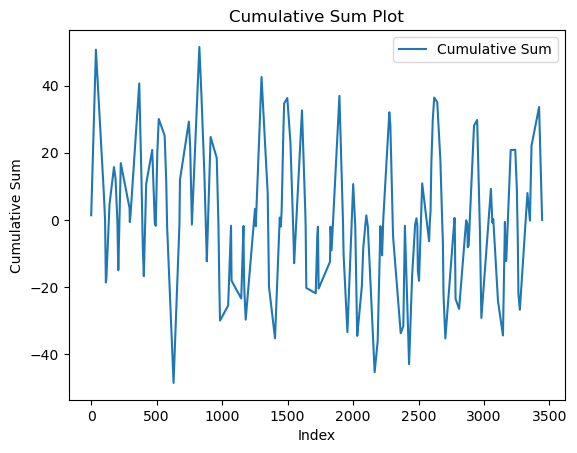

In [891]:
# Объединяем массивы
hurst_flat = np.concatenate(hurst_)  
from scipy import signal
hurst_flat = signal.detrend(hurst_flat)

hurst_cumsum = np.cumsum(hurst_flat)  # Считаем накопленную сумму

# Построение графика
plt.plot(hurst_cumsum, label="Cumulative Sum")
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.title("Cumulative Sum Plot")
plt.legend()
plt.show()

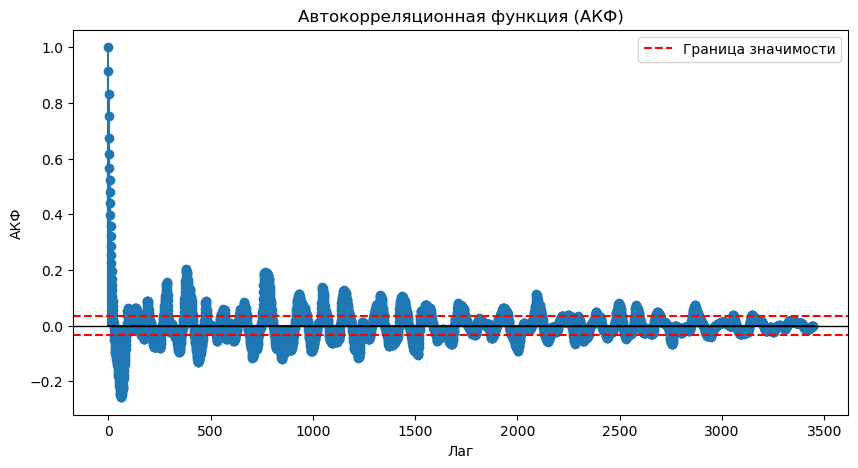

In [893]:
Z = hurst_cumsum
lags = len(Z) - 1
# lags = 300
acf_values = acf(hurst_flat, nlags=lags, fft=True)
N = len(acf_values)
# Визуализация
plt.figure(figsize=(10, 5))
plt.stem(range(lags + 1), acf_values, basefmt="b")  # basefmt="b" = синий маркер на оси
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=1.96/np.sqrt(N), linestyle='--', color='red', label="Граница значимости")
plt.axhline(y=-1.96/np.sqrt(N), linestyle='--', color='red')
plt.xlabel('Лаг')
plt.ylabel('АКФ')
plt.title('Автокорреляционная функция (АКФ)')
plt.legend()
plt.show()

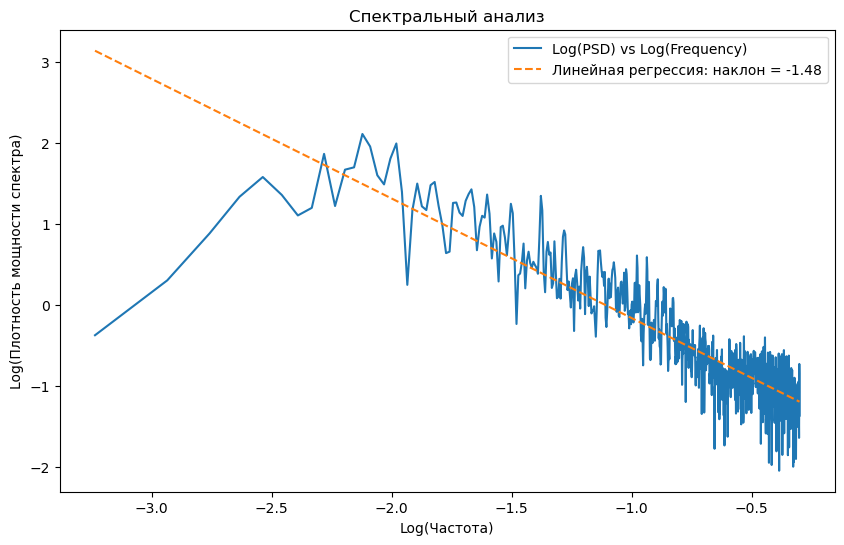

Наклон спектра: -1.48
Параметр Херсста: 1.24


In [895]:
# Применяем FFT
# frequencies, psd = signal.welch(hurst_flat, fs=1)  # fs=1, так как мы работаем с дискретным временным рядом
frequencies, psd = signal.welch(hurst_flat, fs=1, nperseg=len(hurst_flat)//2)
# Преобразуем PSD в логарифмическую шкалу
# log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту
# log_psd = np.log(psd[1:])  # Убираем нулевое значение мощности
# mask = (frequencies > 0.01) & (frequencies < 0.5)  # Пример фильтра
# log_frequencies = np.log10(frequencies[mask])
# log_psd = np.log10(psd[mask])
log_frequencies = np.log10(frequencies[1:])
log_psd = np.log10(psd[1:])
# Линейная регрессия для нахождения наклона
slope, intercept = np.polyfit(log_frequencies, log_psd, 1)
# log_frequencies = np.log10(frequencies[1:])
# log_psd = np.log10(psd[1:])
# slope, interccept = np.polyfit(log_frequencies, log_psd, 1)
H = (-slope + 1) / 2

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(log_frequencies, log_psd, label="Log(PSD) vs Log(Frequency)")
plt.plot(log_frequencies, slope * log_frequencies + intercept, '--', label=f'Линейная регрессия: наклон = {slope:.2f}')
plt.xlabel('Log(Частота)')
plt.ylabel('Log(Плотность мощности спектра)')
plt.title('Спектральный анализ')
plt.legend()
plt.show()

# Выводим наклон спектра
print(f"Наклон спектра: {slope:.2f}")
print(f"Параметр Херсста: {H:.2f}")

In [897]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(hurst_flat)
print('ADF p-value:', result[1])  # Если < 0.05 → стационарен

ADF p-value: 9.464716839851721e-21


In [899]:
# Возьмите разности исходного ряда
diff_series = np.diff(hurst_flat)

# Проверьте стационарность приращений
result_diff = adfuller(diff_series)
print('ADF p-value для приращений:', result_diff[1])

ADF p-value для приращений: 3.0155715809893056e-30


In [901]:
diff_series = np.diff(Z)
result_diff = adfuller(diff_series)
print('ADF p-value для приращений:', result_diff[1])

ADF p-value для приращений: 9.350878006577196e-21


Визуализация спектра 

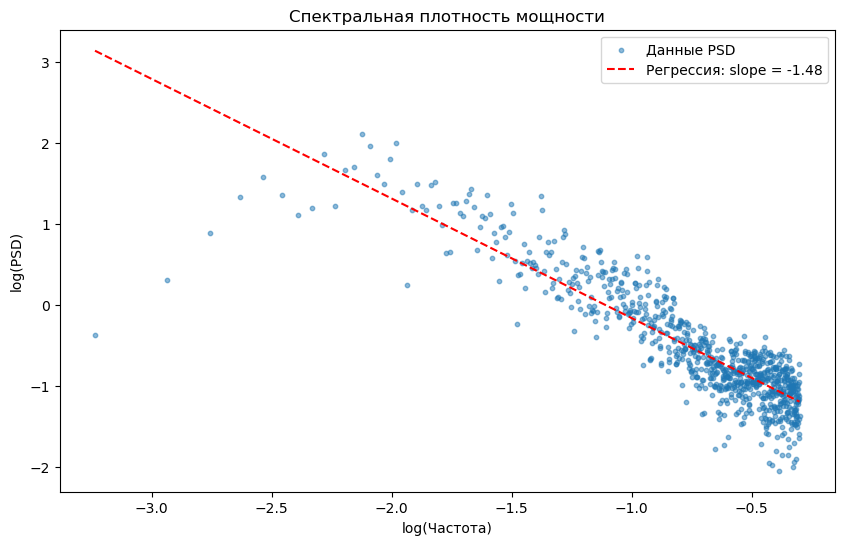

In [904]:
plt.figure(figsize=(10, 6))
plt.scatter(log_frequencies, log_psd, s=10, alpha=0.5, label="Данные PSD")
plt.plot(log_frequencies, slope * log_frequencies + intercept, 
         'r--', 
         label=f'Регрессия: slope = {slope:.2f}')
plt.xlabel('log(Частота)')
plt.ylabel('log(PSD)')
plt.title('Спектральная плотность мощности')
plt.legend()
plt.show()

R/S анализ

In [812]:
def hurst_rs(series):
    lags = range(2, 10)
    tau = [np.std(np.subtract(series[lag:], series[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]
H_rs = hurst_rs(hurst_flat)
print(f"Параметр Херста (R/S): {H_rs:.2f}")

Параметр Херста (R/S): 0.43


И другим подоходм (реализацией)

In [815]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def hurst_rs(series, min_window=10, max_window=None, num_windows=20, plot=True):
    series = np.array(series)
    N = len(series)

    if max_window is None:
        max_window = N // 5

    window_sizes = np.floor(np.logspace(np.log10(min_window), np.log10(max_window), num=num_windows)).astype(int)
    rs_values = []

    for w in window_sizes:
        n_segments = N // w
        rs = []
        for i in range(n_segments):
            segment = series[i * w : (i + 1) * w]
            mean = np.mean(segment)
            dev = segment - mean
            cum_dev = np.cumsum(dev)
            R = np.max(cum_dev) - np.min(cum_dev)
            S = np.std(segment, ddof=1)
            if S > 0:
                rs.append(R / S)
        if rs:
            rs_values.append(np.mean(rs))
        else:
            rs_values.append(np.nan)

    log_n = np.log10(window_sizes)
    log_rs = np.log10(rs_values)

    mask = ~np.isnan(log_rs)
    slope, intercept, r_value, _, _ = linregress(log_n[mask], log_rs[mask])
    H = slope

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(log_n, log_rs, 'o-', label='log(R/S) vs log(n)')
        plt.plot(log_n[mask], intercept + slope * log_n[mask], '--', label=f'Наклон = H = {H:.3f}')
        plt.xlabel('log окна (n)')
        plt.ylabel('log(R/S)')
        plt.title('Оценка Херста методом R/S')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return H


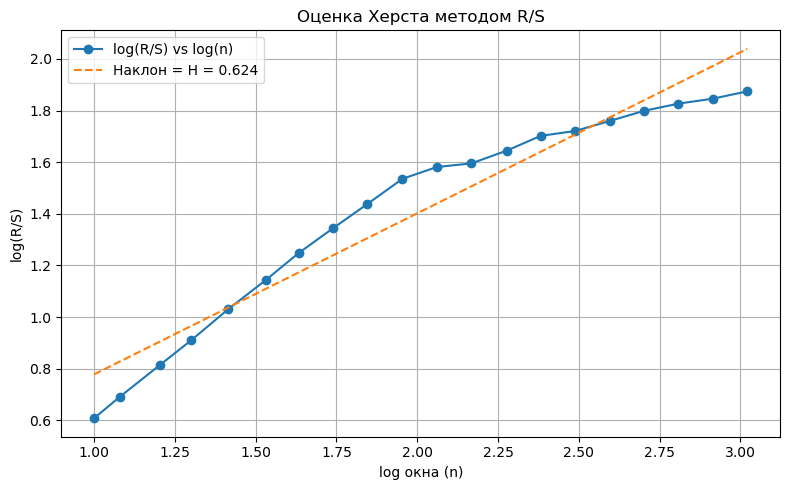

0.6242591856887738

In [817]:
hurst_rs(hurst_flat)

Оценка H по hurst_ (fGn):


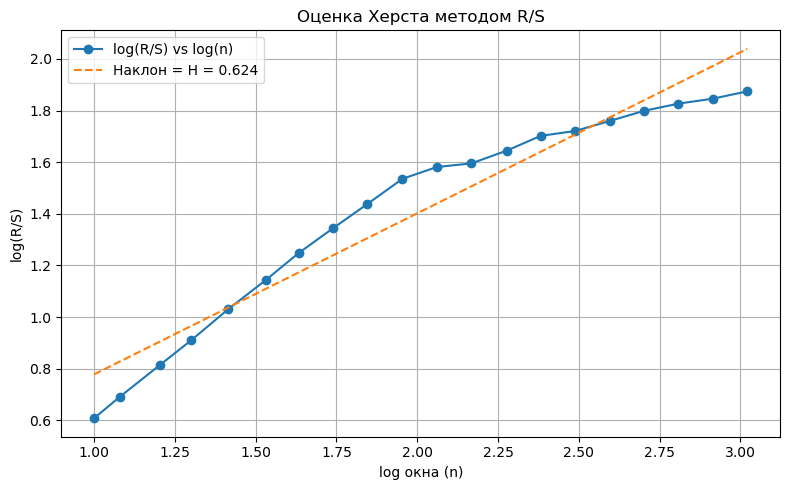

Hurst (R/S) для hurst_: 0.624
Оценка H по cumsum(hurst_) (fBm):


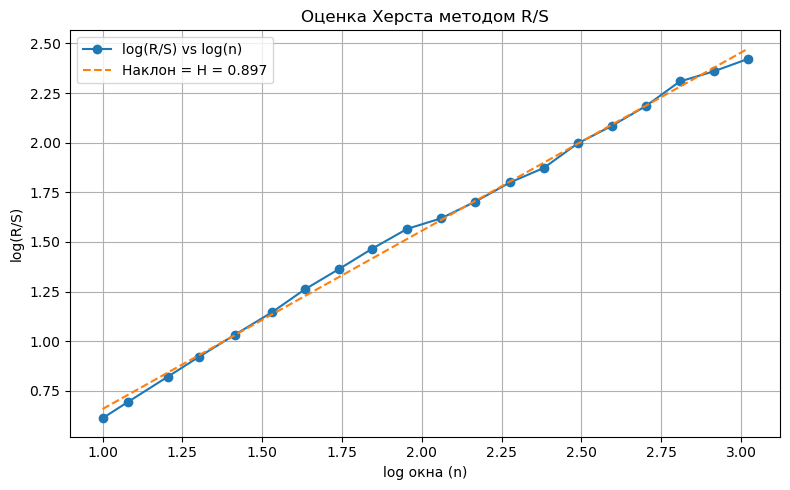

Hurst (R/S) для cumsum(hurst_): 0.897


In [819]:
# 1. По самому hurst_
print("Оценка H по hurst_ (fGn):")
H_fGn = hurst_rs(hurst_flat)
print(f"Hurst (R/S) для hurst_: {H_fGn:.3f}")

# 2. По накопленной сумме
print("Оценка H по cumsum(hurst_) (fBm):")
H_fBm = hurst_rs(np.cumsum(hurst_flat))
print(f"Hurst (R/S) для cumsum(hurst_): {H_fBm:.3f}")

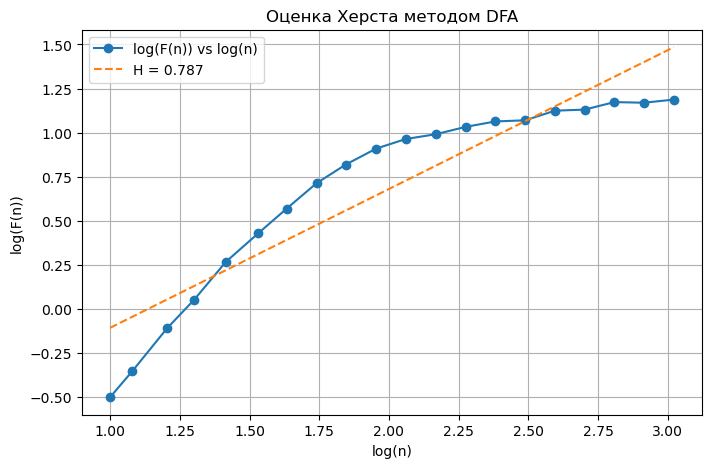

0.7867473950584306

In [820]:
import numpy as np
from numpy import polyfit, log10
import matplotlib.pyplot as plt

def hurst_dfa(series, min_window=10, max_window=None, num_windows=20, plot=True):
    x = np.array(series)
    N = len(x)
    Y = np.cumsum(x - np.mean(x))

    if max_window is None:
        max_window = N // 5

    window_sizes = np.floor(np.logspace(np.log10(min_window), np.log10(max_window), num=num_windows)).astype(int)
    F_n = []

    for n in window_sizes:
        n_segments = N // n
        fluctuations = []
        for i in range(n_segments):
            segment = Y[i * n: (i + 1) * n]
            if len(segment) < n: continue
            t = np.arange(n)
            coeffs = polyfit(t, segment, 1)
            trend = coeffs[0] * t + coeffs[1]
            detrended = segment - trend
            fluctuations.append(np.sqrt(np.mean(detrended**2)))
        if fluctuations:
            F_n.append(np.mean(fluctuations))
        else:
            F_n.append(np.nan)

    log_n = log10(window_sizes)
    log_F = log10(F_n)

    mask = ~np.isnan(log_F)
    slope, intercept = polyfit(log_n[mask], log_F[mask], 1)
    H = slope

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(log_n, log_F, 'o-', label='log(F(n)) vs log(n)')
        plt.plot(log_n[mask], intercept + slope * log_n[mask], '--', label=f'H = {H:.3f}')
        plt.xlabel('log(n)')
        plt.ylabel('log(F(n))')
        plt.title('Оценка Херста методом DFA')
        plt.legend()
        plt.grid(True)
        plt.show()

    return H
hurst_dfa(hurst_flat)

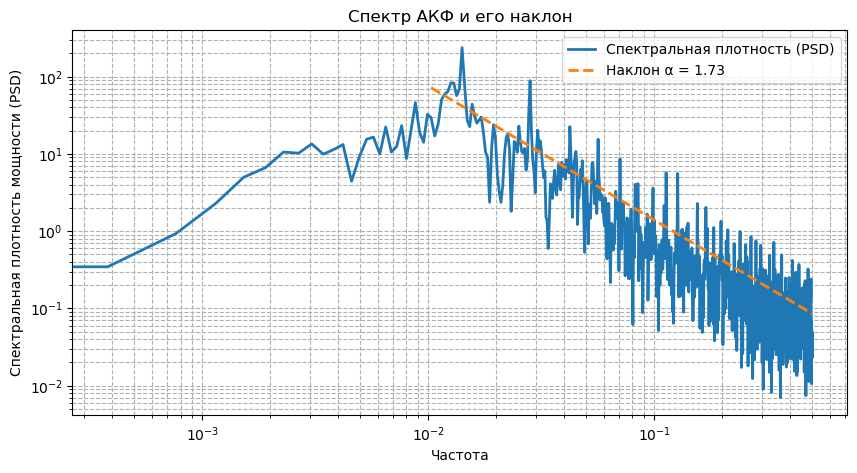

Найденный наклон спектра α ≈ 1.73


In [823]:
from scipy.signal import welch
from scipy.optimize import curve_fit
# Данные АКФ
# lags = len(total_)
# acf_values = acf(total_, nlags=lags, fft=True)


# 1. Вычисляем спектральную плотность мощности (PSD)
frequencies, psd = welch(hurst_flat, fs=1.0, nperseg=len(acf_values)//2)

# 2. Функция для степенного закона: S(f) ~ f^(-alpha)
def power_law(f, a, alpha):
    return a * f ** (-alpha)

# 3. Фитируем наклон спектра в логарифмическом масштабе
valid = (frequencies > 0.01) & (frequencies < 0.5)  # Ограничим диапазон частот
popt, _ = curve_fit(power_law, frequencies[valid], psd[valid])

# 4. Визуализация спектра и аппроксимации
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, psd, label="Спектральная плотность (PSD)", linewidth=2)
plt.loglog(frequencies[valid], power_law(frequencies[valid], *popt), '--', 
           label=f"Наклон α = {popt[1]:.2f}", linewidth=2)

plt.xlabel("Частота")
plt.ylabel("Спектральная плотность мощности (PSD)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.title("Спектр АКФ и его наклон")
plt.show()

print(f"Найденный наклон спектра α ≈ {popt[1]:.2f}")

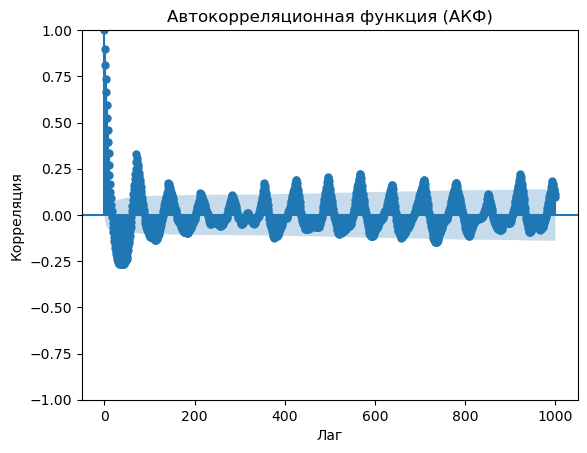

In [825]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Построение графика АКФ с лагами до 100
plot_acf(hurst_flat, lags=1000, alpha=0.05, title='Автокорреляционная функция (АКФ)')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.show()

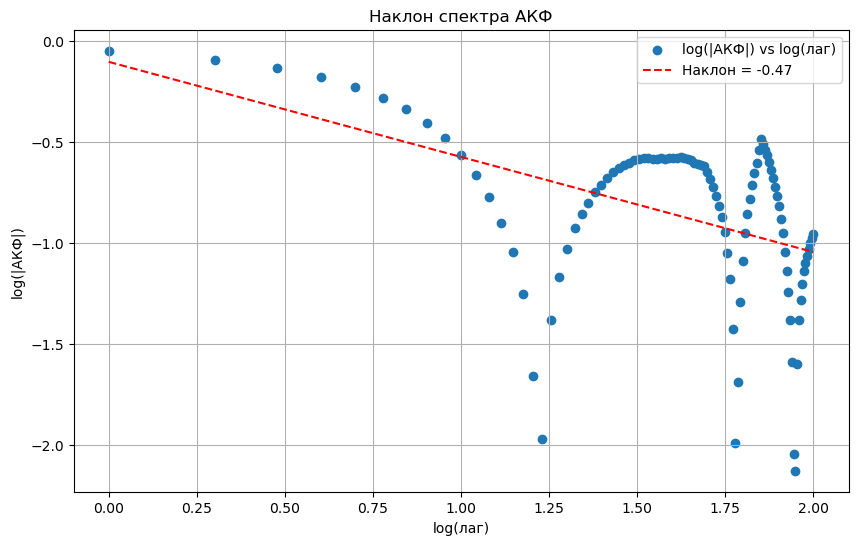

Hurst:  0.7643117034101319


In [827]:
import numpy as np
from scipy.stats import linregress

# Вычисление АКФ
from statsmodels.tsa.stattools import acf
acf_values = acf(hurst_flat, nlags=100, fft=True)

# Удаление нулевого лага (значение 1.0)
lags = np.arange(1, len(acf_values))
log_acf = np.log10(np.abs(acf_values[1:]))
log_lags = np.log10(lags)

# Линейная регрессия
slope, intercept, r_value, p_value, std_err = linregress(log_lags, log_acf)

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(log_lags, log_acf, label='log(|АКФ|) vs log(лаг)')
plt.plot(log_lags, intercept + slope * log_lags, '--', color='red', 
         label=f'Наклон = {slope:.2f}')
plt.xlabel('log(лаг)')
plt.ylabel('log(|АКФ|)')
plt.title('Наклон спектра АКФ')
plt.legend()
plt.grid(True)
plt.show()
print("Hurst: ", 1 + slope / 2)

In [829]:
from scipy import signal
detrended_series = signal.detrend(hurst_flat)

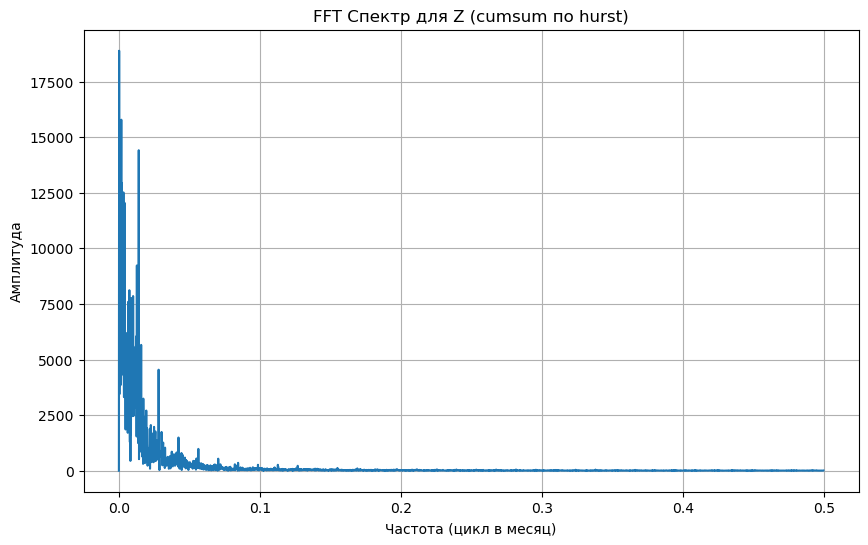

In [831]:
# Пример массива Z (замените на ваш массив данных)
Z = hurst_cumsum  # ваш массив данных (например, cumsum по hurst)

# Применяем FFT
fft_values = np.fft.fft(Z)

# Получаем соответствующие частоты
frequencies = np.fft.fftfreq(len(Z), d=1)  # d=1, так как шаг 1 месяц

# Модуль FFT (амплитуда)
fft_magnitude = np.abs(fft_values)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(frequencies)//2])  # Отображаем только положительные частоты
plt.xlabel('Частота (цикл в месяц)')
plt.ylabel('Амплитуда')
plt.title('FFT Спектр для Z (cumsum по hurst)')
plt.grid(True)
plt.show()

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_32157/2491044368.py:13: RuntimeWarning: invalid value encountered in log
  log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту


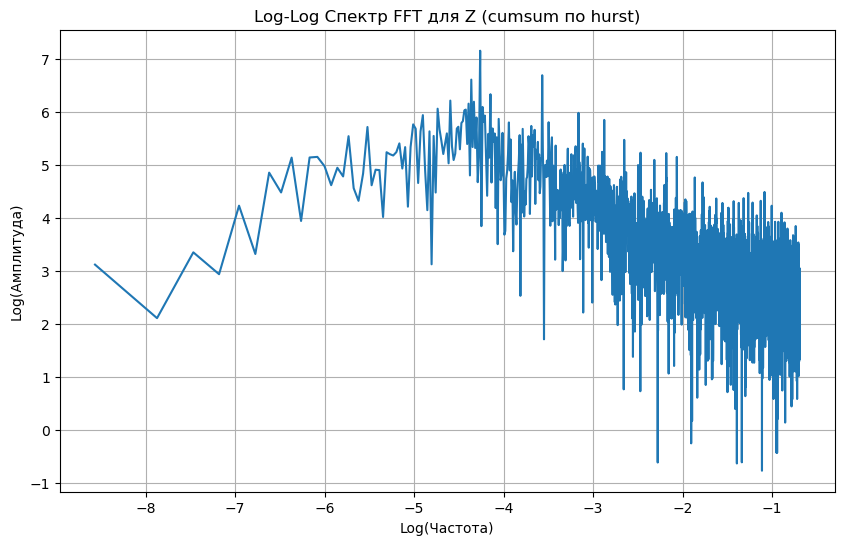

In [833]:
Z = hurst_cumsum  # ваш массив данных (например, cumsum по hurst)

# Применяем FFT
fft_values = np.fft.fft(hurst_flat)

# Получаем соответствующие частоты
frequencies = np.fft.fftfreq(len(Z), d=1)  # d=1, так как шаг 1 месяц

# Модуль FFT (амплитуда)
fft_magnitude = np.abs(fft_values)

# Преобразуем в логарифмическую шкалу
log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту
log_fft_magnitude = np.log(fft_magnitude[1:])  # Убираем нулевую амплитуду

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(log_frequencies, log_fft_magnitude)
plt.xlabel('Log(Частота)')
plt.ylabel('Log(Амплитуда)')
plt.title('Log-Log Спектр FFT для Z (cumsum по hurst)')
plt.grid(True)
plt.show()

In [835]:
# Функция для вычисления R/S
def hurst_exponent(time_series):
    n = len(time_series)
    # Инициализация списков для R/S
    rs_values = []
    segment_lengths = []

    # Разбиваем временной ряд на сегментыё
    for seg_len in range(10, n // 2, 10):  # Мы будем использовать сегменты длиной от 10 до n/2
        segments = [time_series[i:i+seg_len] for i in range(0, n, seg_len) if i+seg_len <= n]
        for segment in segments:
            # Среднее значение в сегменте
            mean_val = np.mean(segment)
            # Размах сегмента (максимум - минимум)
            R = np.max(segment) - np.min(segment)
            # Стандартное отклонение
            S = np.std(segment)
            if S != 0:
                rs_values.append(R / S)
                segment_lengths.append(seg_len)

    # Линейная регрессия для log(R/S) против log(длина сегмента)
    log_rs = np.log(rs_values)
    log_lengths = np.log(segment_lengths)

    # Линейная регрессия для нахождения наклона
    slope, intercept = np.polyfit(log_lengths, log_rs, 1)

    return slope  # Наклон — это и есть параметр Херста

# Пример использования для вашего массива Z (например, hurst_cumsum)
hurst_value = hurst_exponent(hurst_flat)

In [837]:
hurst_value

0.20215516947887133